## U-Net图像分割

在《如何使用Mask RCNN模型进行图像实体分割？》一文中提到了用Mask-RCNN来做气球分割，官网之中也有对应的代码，本着练习的态度，那么笔者就拿来这个数据集继续练手，最麻烦的仍然是如何得到标注数据。MaskRCNN的开源code为[Mask R-CNN - Inspect Balloon Training Data](https://github.com/matterport/Mask_RCNN/blob/v2.1/samples/balloon/inspect_balloon_data.ipynb)

In [1]:
import os
import sys
import random
import warnings
import json
import datetime
import skimage.draw
from skimage import io


sys.path.append('/mnt/unet/')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

# 限制GPU使用量
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

# Set some parameters


warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed


Using TensorFlow backend.


## Get the data
Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now!


In [277]:


def get_mask(a,dataset_dir):
    image_path = os.path.join(dataset_dir, a['filename'])
    image = io.imread(image_path)
    height, width = image.shape[:2]
    polygons = [r['shape_attributes'] for r in a['regions'].values()]
    mask = np.zeros([height, width, len(polygons)],dtype=np.uint8) 

    for i, p in enumerate(polygons):
        # Get indexes of pixels inside the polygon and set them to 1
        rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
        mask[rr, cc, i] = 1

    mask, class_ids = mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
    
    #boxes = extract_bboxes(mask)
    boxes = extract_bboxes(resize(mask, (128, 128), mode='constant',preserve_range=True))
    
    unique_class_ids = np.unique(class_ids)
    mask_area = [np.sum(mask[:, :, np.where(class_ids == i)[0]])
                     for i in unique_class_ids]
    top_ids = [v[0] for v in sorted(zip(unique_class_ids, mask_area),
                                    key=lambda r: r[1], reverse=True) if v[1] > 0]

    class_id = top_ids[0]
    # Pull masks of instances belonging to the same class.
    m = mask[:, :, np.where(class_ids == class_id)[0]]
    m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)

    return m,image,height,width,class_ids,boxes

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# trainset
annotations_path = "/mnt/unet/bolloon/balloon/train/via_region_data.json"
dataset_dir = '/mnt/unet/bolloon/balloon/train'

annotations = json.load(open(annotations_path))
train_ids = list(annotations.keys())
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
train_boxes = []
for n,tid in tqdm(enumerate(train_ids), total=len(train_ids)):
    a = annotations[tid]
    mask_,img,_,_,_,boxes = get_mask(a,dataset_dir)
    train_boxes.append(boxes)
    mask_ = np.expand_dims(resize(mask_, (IMG_WIDTH, IMG_HEIGHT), mode='constant',preserve_range=True), axis=-1)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) # resize成128*128
    Y_train[n] = mask_
    X_train[n] = img

# testset
annotations_test_path = "/mnt/unet/bolloon/balloon/val/via_region_data.json"
testset_dir = '/mnt/unet/bolloon/balloon/val'

annotations_test = json.load(open(annotations_test_path))
test_ids = list(annotations_test.keys())
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
sizes_test = []
test_boxes = []

print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, tid in tqdm(enumerate(test_ids), total=len(test_ids)):
    a = annotations_test[tid]
    mask_,img,height,width,_,boxes = get_mask(a,testset_dir)
    test_boxes.append(boxes)
    sizes_test.append([height, width])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    mask_ = np.expand_dims(resize(mask_, (IMG_WIDTH, IMG_HEIGHT), mode='constant',preserve_range=True), axis=-1)
    Y_test[n] = mask_
    X_test[n] = img    


  0%|          | 0/61 [00:00<?, ?it/s]

Getting and resizing train images and masks ... 


100%|██████████| 61/61 [00:19<00:00,  3.15it/s]


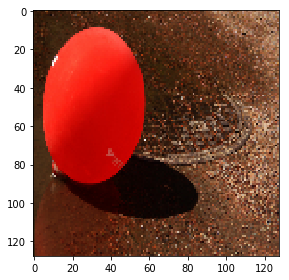

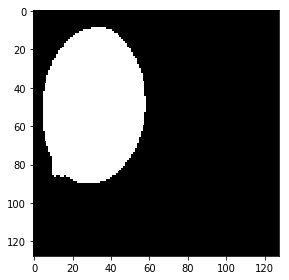

In [202]:
# Check if training data looks all right
# 查看数据是否正确
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

## Create our Keras metric
Now we try to define the mean average precision at different intersection over union (IoU) thresholds metric in Keras. TensorFlow has a mean IoU metric, but it doesn't have any native support for the mean over multiple thresholds, so I tried to implement this. I'm by no means certain that this implementation is correct, though! Any assistance in verifying this would be most welcome!

Update: This implementation is most definitely not correct due to the very large discrepancy between the results reported here and the LB results. It also seems to just increase over time no matter what when you train ...

In [7]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

## Build and train our neural network

Next we build our U-Net model, loosely based on U-Net: Convolutional Networks for Biomedical Image Segmentation and very similar to this repo from the Kaggle Ultrasound Nerve Segmentation competition.

![模型结构图](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)



In [8]:
def UNetModel(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
    return model

model = UNetModel(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

## Fit model

I'll just train for 10 epochs, which takes around 10 minutes in the Kaggle kernel with the current parameters.

Update: Added early stopping and checkpointing and increased to 30 epochs.

ou should easily be able to stabilize and improve the results just by changing a few parameters, tweaking the architecture a little bit and training longer with early stopping.

In [203]:
def model_fit(X_train,Y_train,model_name,epochs,batch_size,validation_split,patience=5, verbose=1):
    earlystopper = EarlyStopping(patience=patience, verbose=verbose)
    checkpointer = ModelCheckpoint(model_name, verbose=verbose, save_best_only=True)
    results = model.fit(X_train, Y_train, validation_split=validation_split, 
                        batch_size=batch_size, epochs=epochs, 
                        callbacks=[earlystopper, checkpointer])

model_name = 'model-bolloon.h5'
epochs = 300
batch_size = 8
validation_split = 0.1
model_fit(X_train,Y_train,model_name,epochs,batch_size,validation_split,patience = 60)

Train on 54 samples, validate on 7 samples
Epoch 1/300
54/54 [==============================] - 5s 97ms/step - loss: 0.1092 - mean_iou: 0.7278 - val_loss: 0.5309 - val_mean_iou: 0.8411
Epoch 2/300
54/54 [==============================] - 0s 6ms/step - loss: 0.0920 - mean_iou: 0.8275 - val_loss: 0.5184 - val_mean_iou: 0.8289
Epoch 3/300
54/54 [==============================] - 0s 4ms/step - loss: 0.0755 - mean_iou: 0.8249 - val_loss: 0.5911 - val_mean_iou: 0.8315
Epoch 4/300
54/54 [==============================] - 0s 5ms/step - loss: 0.0614 - mean_iou: 0.8327 - val_loss: 0.5732 - val_mean_iou: 0.8386
Epoch 5/300
54/54 [==============================] - 0s 5ms/step - loss: 0.0596 - mean_iou: 0.8396 - val_loss: 0.6708 - val_mean_iou: 0.8451
Epoch 6/300
54/54 [==============================] - 0s 5ms/step - loss: 0.0768 - mean_iou: 0.8411 - val_loss: 0.6332 - val_mean_iou: 0.8448
Epoch 7/300
54/54 [==============================] - 0s 5ms/step - loss: 0.0716 - mean_iou: 0.8442 - val_loss:

Epoch 32/300
54/54 [==============================] - 0s 5ms/step - loss: 0.0127 - mean_iou: 0.9055 - val_loss: 1.0496 - val_mean_iou: 0.9066
Epoch 33/300
54/54 [==============================] - 0s 5ms/step - loss: 0.0126 - mean_iou: 0.9067 - val_loss: 1.0559 - val_mean_iou: 0.9076
Epoch 34/300
54/54 [==============================] - 0s 4ms/step - loss: 0.0122 - mean_iou: 0.9076 - val_loss: 1.0470 - val_mean_iou: 0.9086
Epoch 35/300
54/54 [==============================] - 0s 4ms/step - loss: 0.0116 - mean_iou: 0.9085 - val_loss: 1.0658 - val_mean_iou: 0.9096
Epoch 36/300
54/54 [==============================] - 0s 4ms/step - loss: 0.0114 - mean_iou: 0.9096 - val_loss: 1.0788 - val_mean_iou: 0.9105
Epoch 37/300
54/54 [==============================] - 0s 4ms/step - loss: 0.0113 - mean_iou: 0.9104 - val_loss: 1.0695 - val_mean_iou: 0.9114
Epoch 38/300
54/54 [==============================] - 0s 4ms/step - loss: 0.0107 - mean_iou: 0.9114 - val_loss: 1.0901 - val_mean_iou: 0.9122
Epoch 

## Make predictions 预测
Let's make predictions both on the test set, the val set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.
这边的操作是把trainset按照9:1，分为训练集、验证集，还有一部分是测试集

输入维度:

    X_train (670, 128, 128, 3)
    Y_train (670, 128, 128, 1)
    X_test  (65, 128, 128, 3)

输出维度:
每个像素点的概率[0,1]
    preds_train  (603, 128, 128, 1)
    preds_val    (67, 128, 128, 1)
    preds_test   (65, 128, 128, 1)

这边：
    preds_test_upsampled 是根据测试集结果preds_test，进行上采样得到，还原到了原尺寸

In [204]:
# Predict on train, val and test
model = load_model(model_name, custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1) 
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):],verbose=1)   
preds_test = model.predict(X_test,verbose=1)  

# Threshold predictions
# 二值化
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
# 上采样，回到原来的尺寸
preds_test_upsampled = []  # (65,)
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), # 回到原来的尺寸
                                       mode='constant', preserve_range=True))

13/13 [==============================] - 0s 522us/step


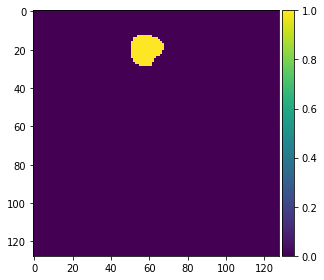

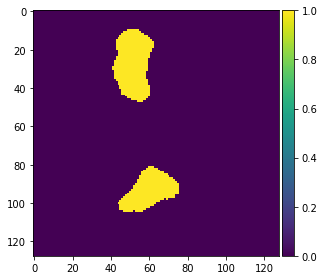

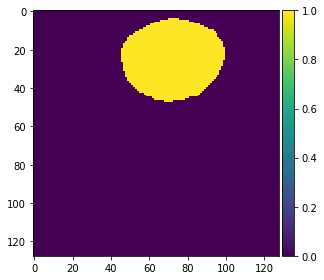

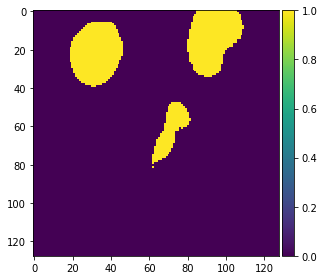

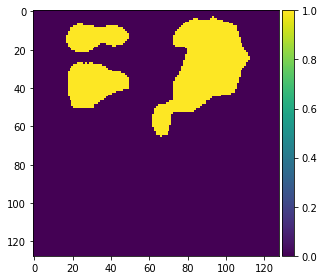

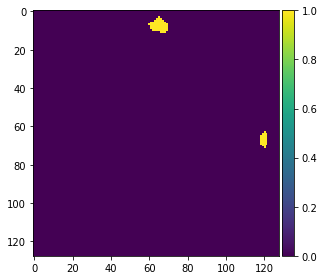

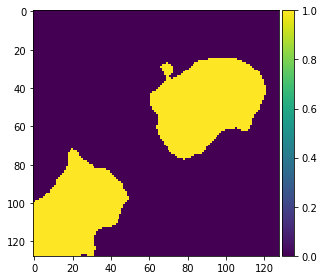

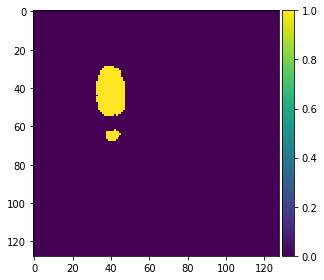

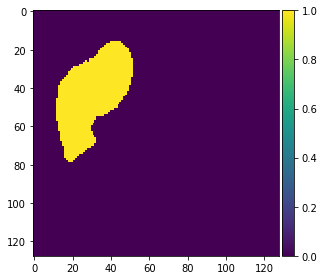

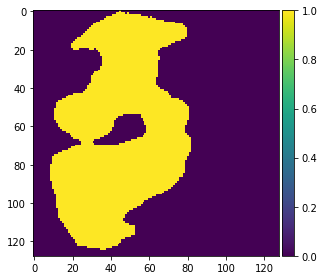

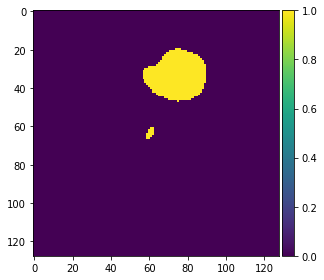

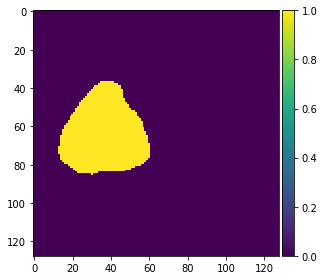

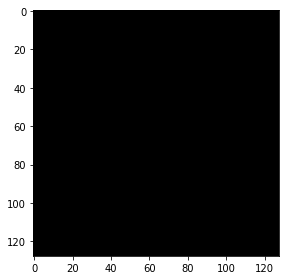

In [156]:
   
def RoundPlot(preds_test_t,train = False):
    for i in range(len(preds_test_t)):
        imshow(np.squeeze(preds_test_t[i]))
        plt.show()

RoundPlot(preds_test_t)

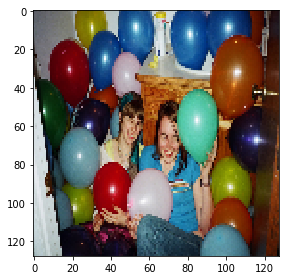

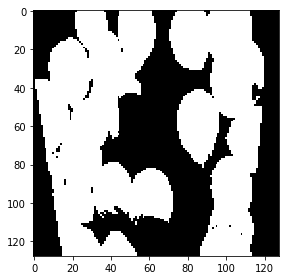

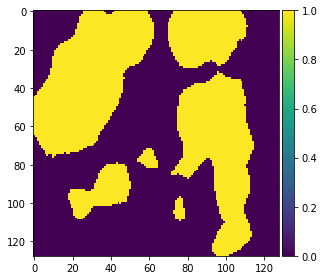

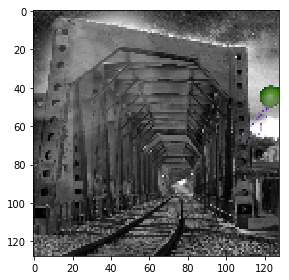

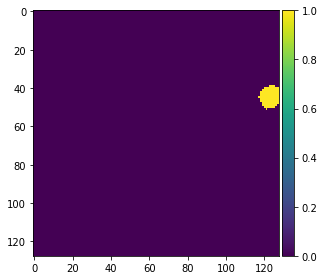

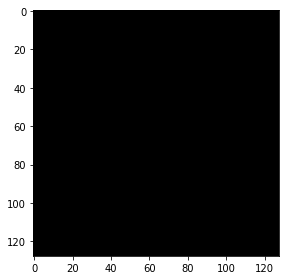

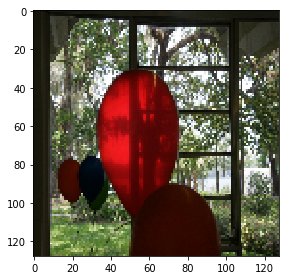

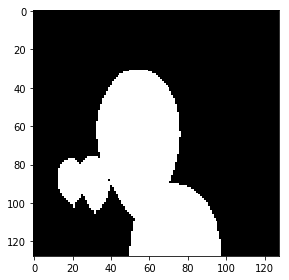

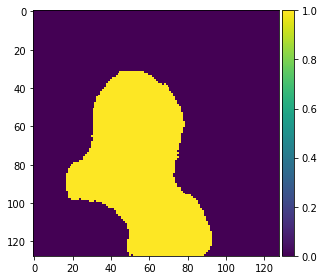

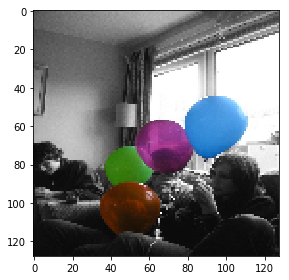

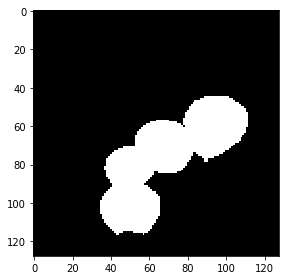

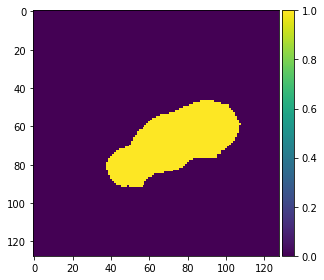

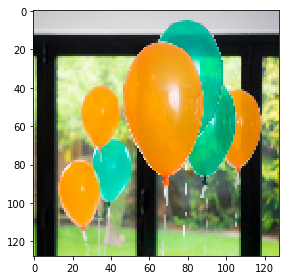

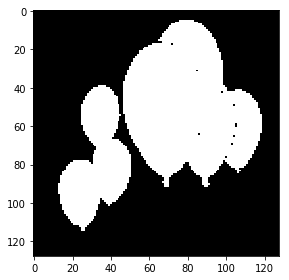

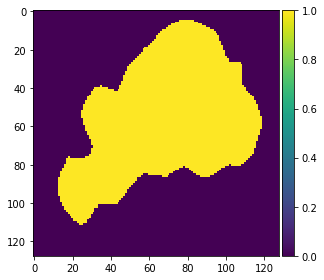

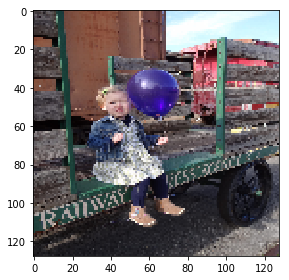

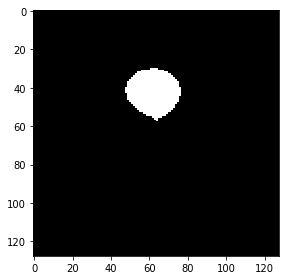

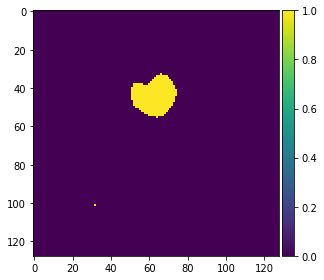

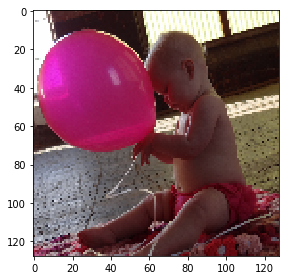

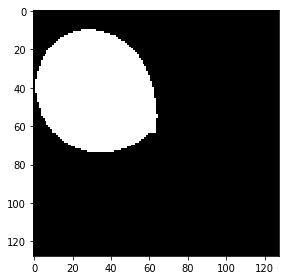

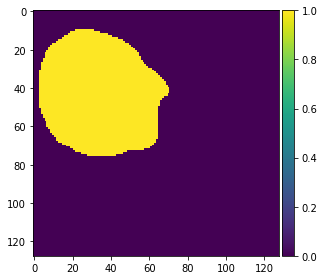

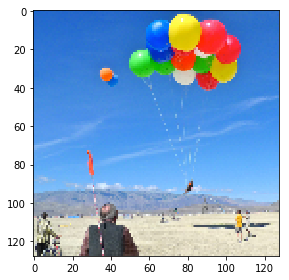

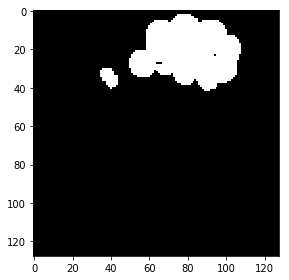

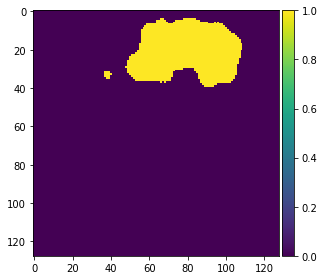

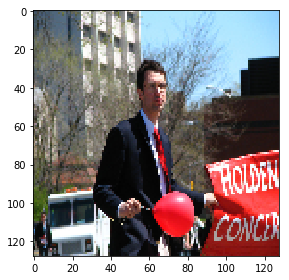

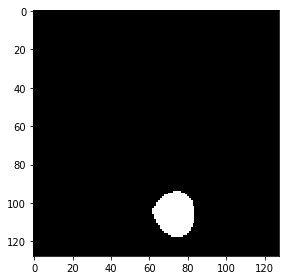

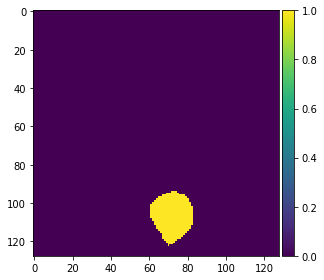

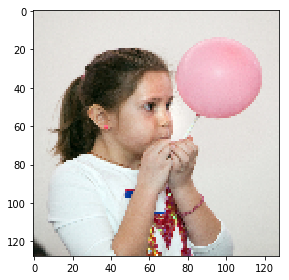

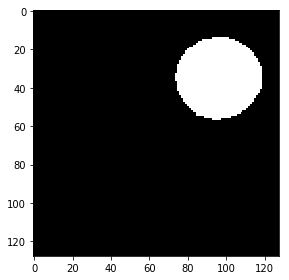

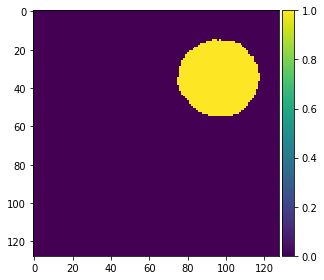

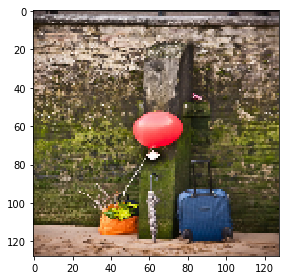

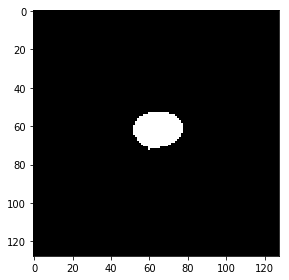

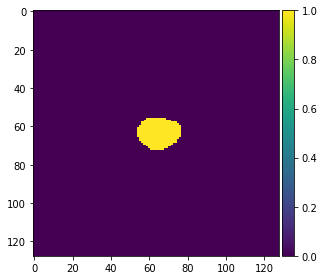

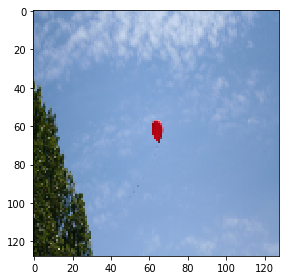

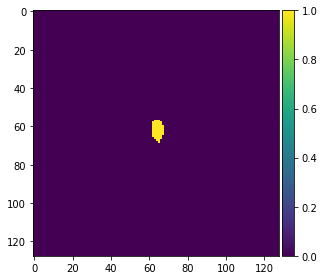

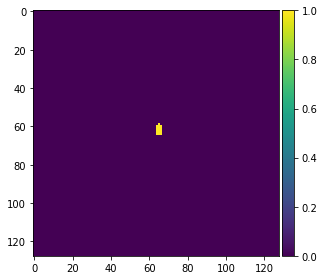

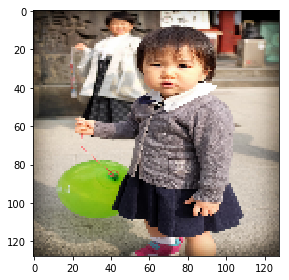

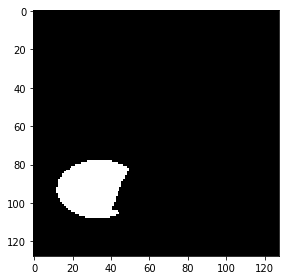

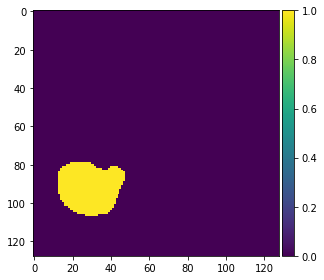

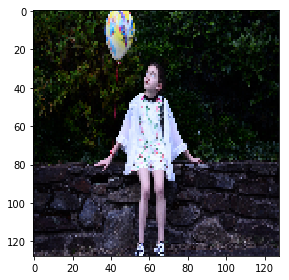

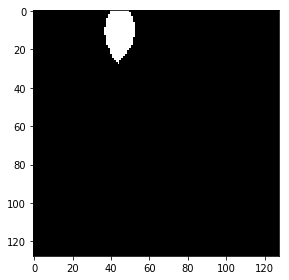

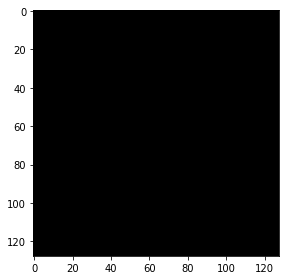

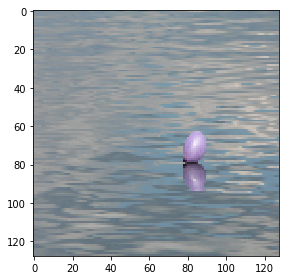

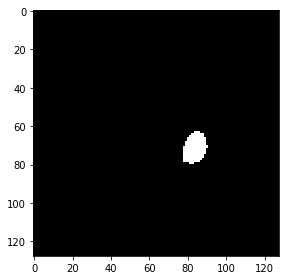

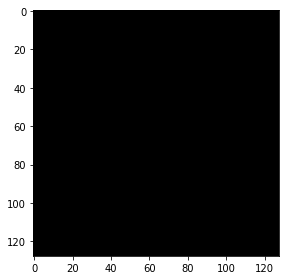

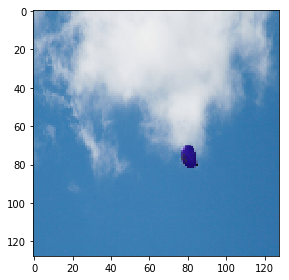

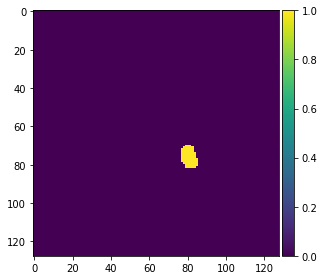

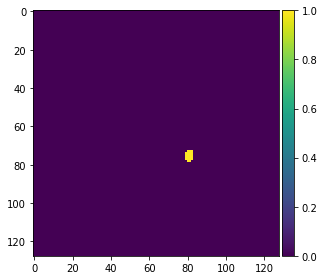

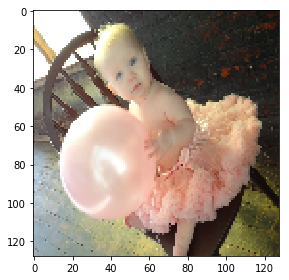

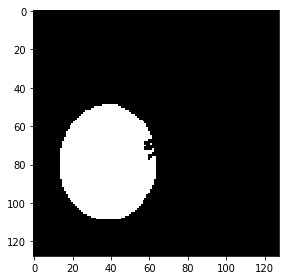

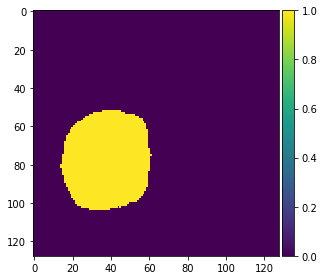

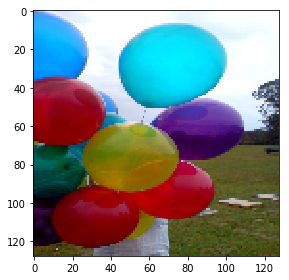

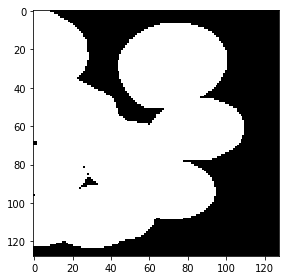

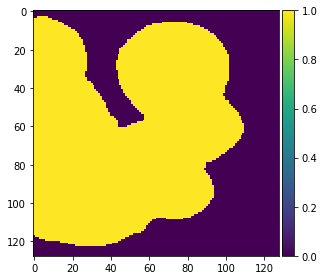

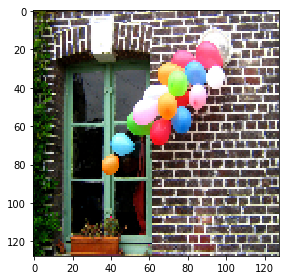

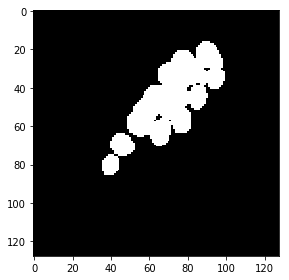

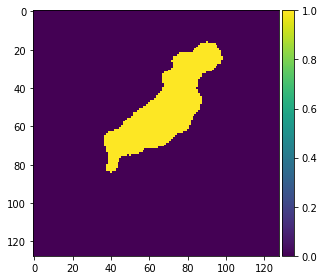

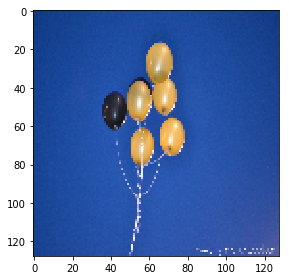

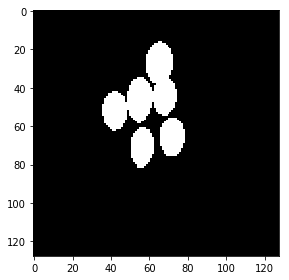

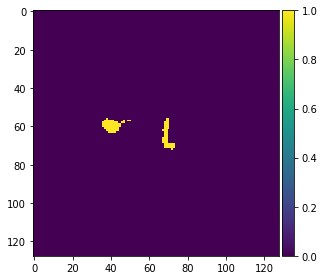

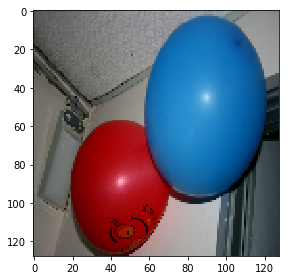

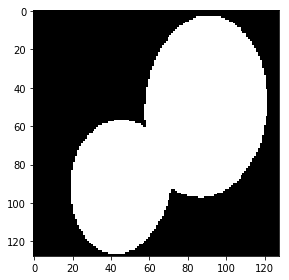

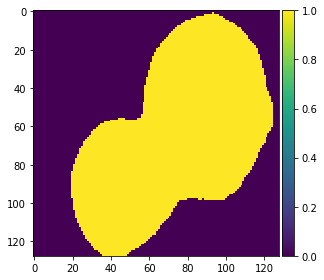

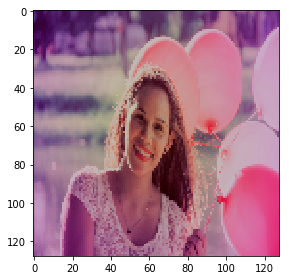

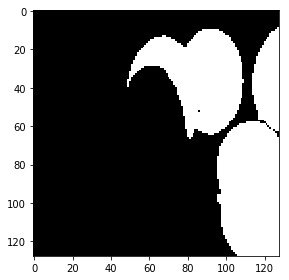

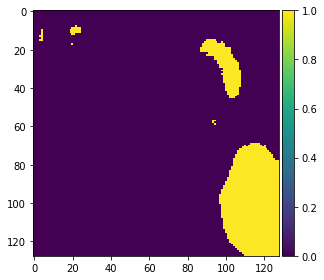

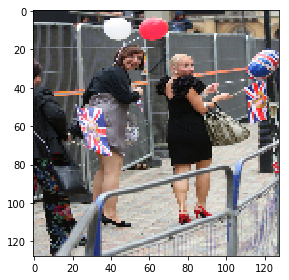

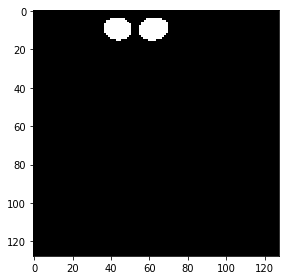

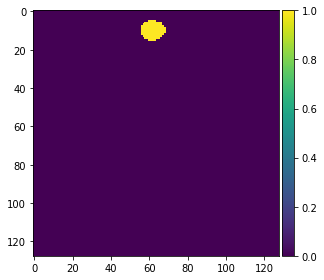

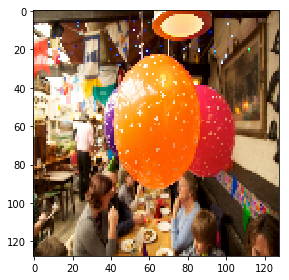

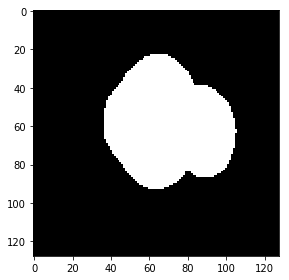

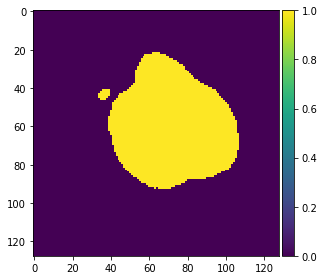

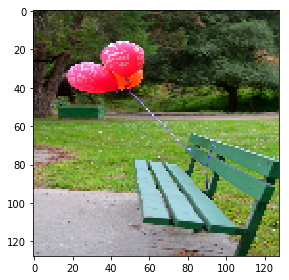

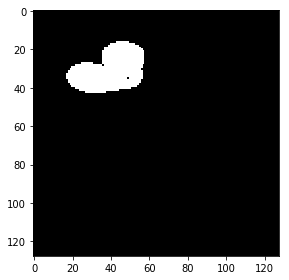

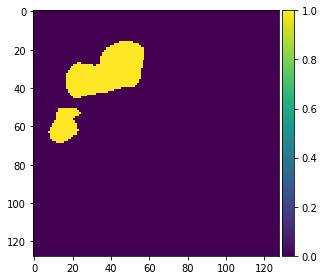

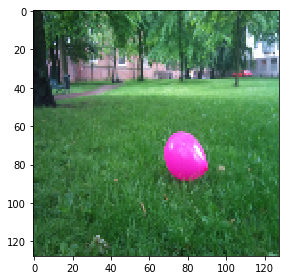

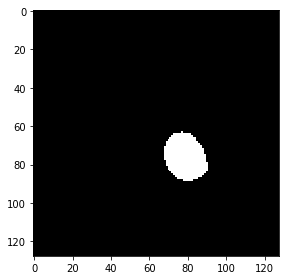

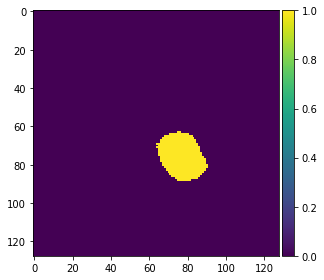

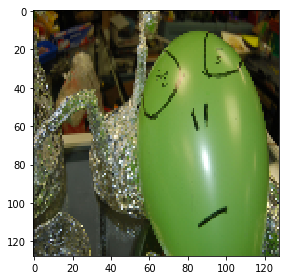

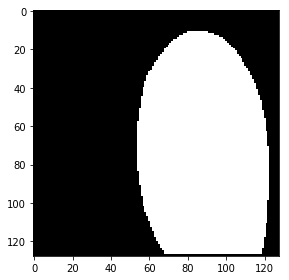

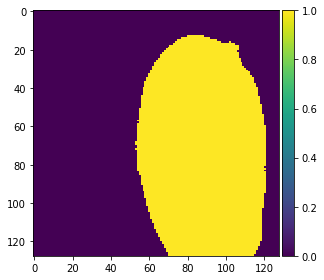

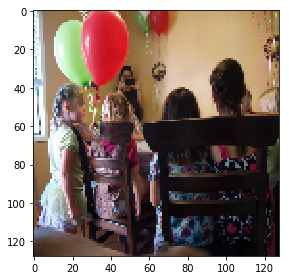

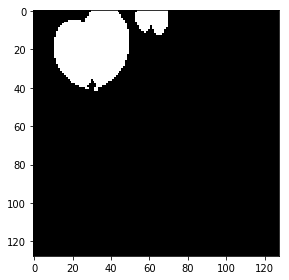

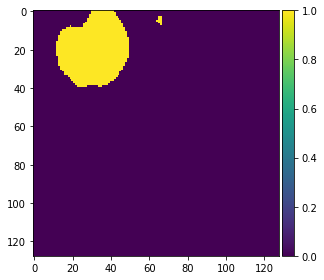

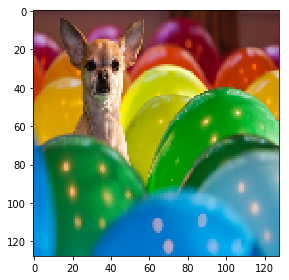

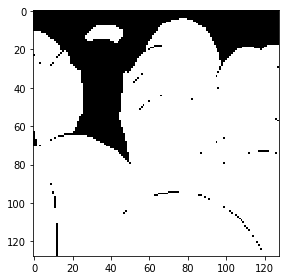

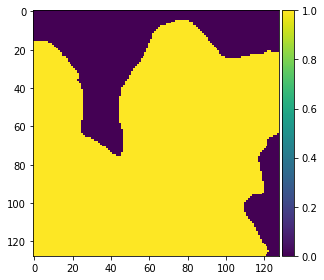

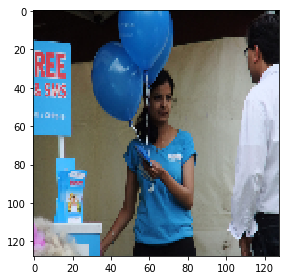

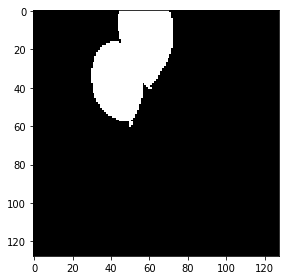

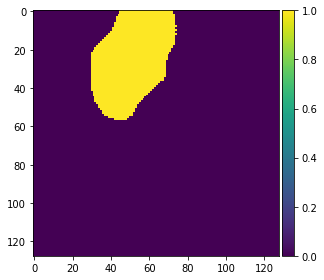

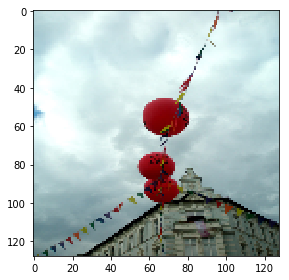

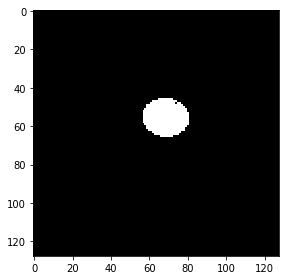

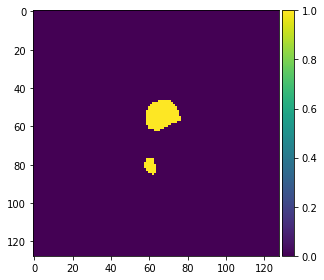

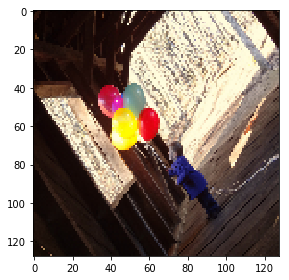

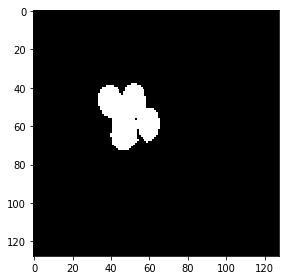

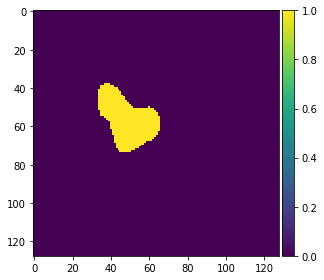

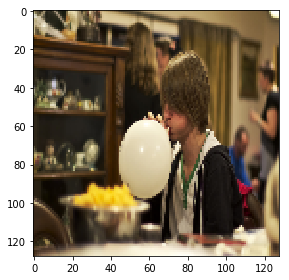

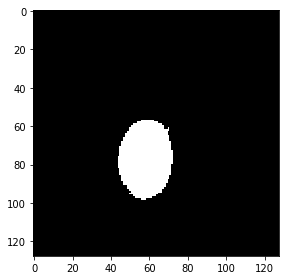

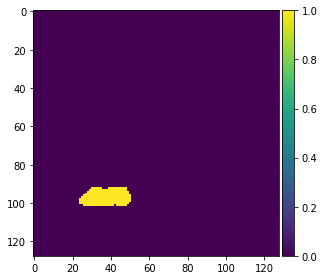

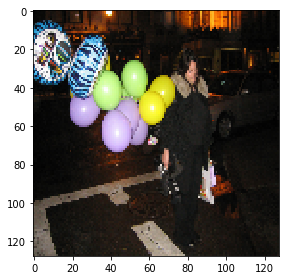

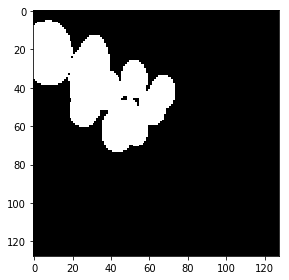

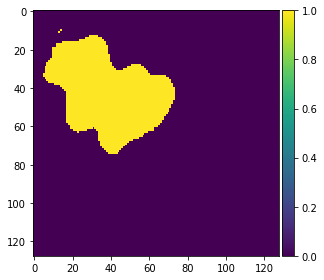

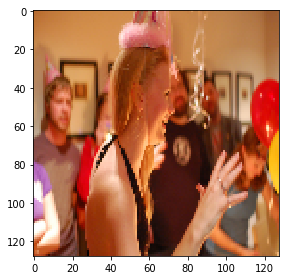

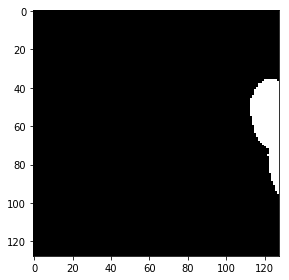

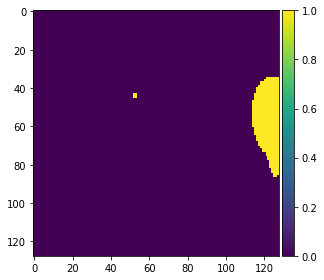

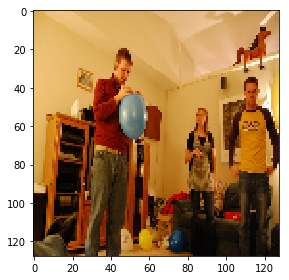

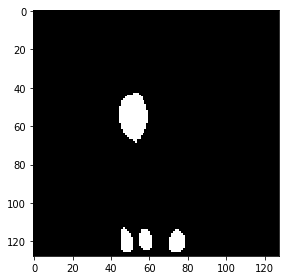

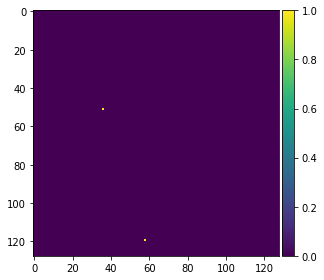

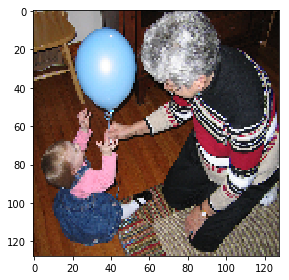

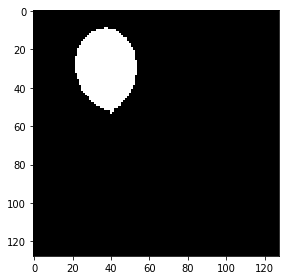

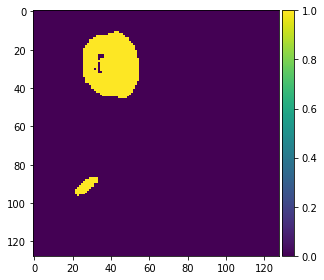

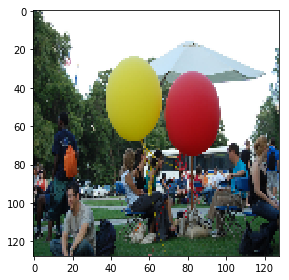

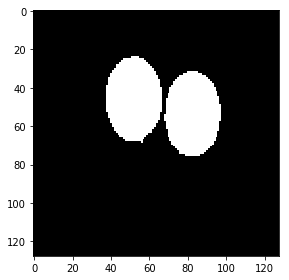

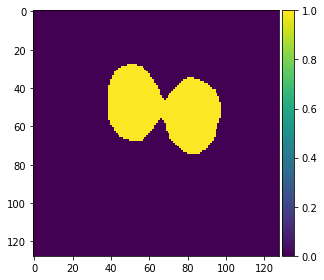

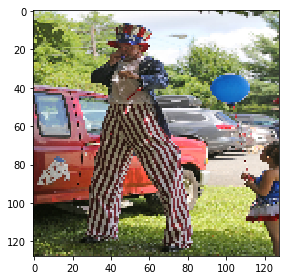

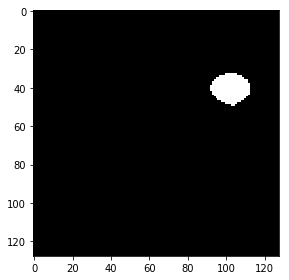

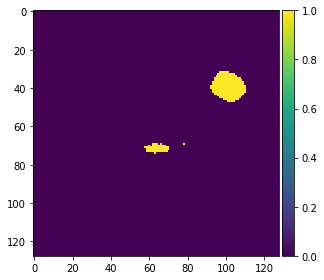

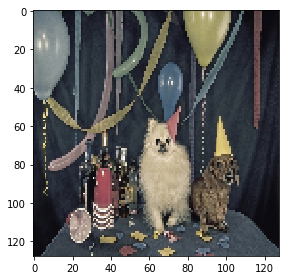

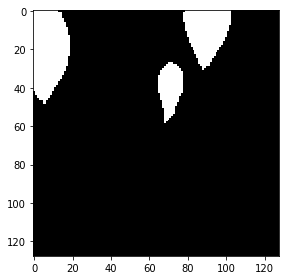

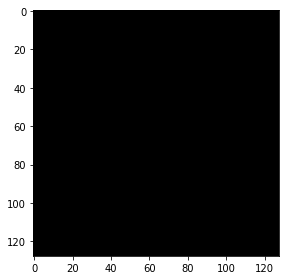

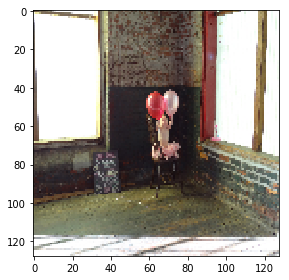

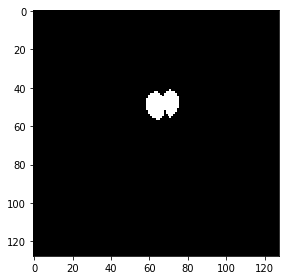

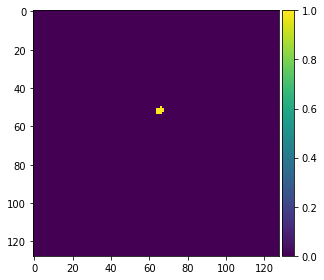

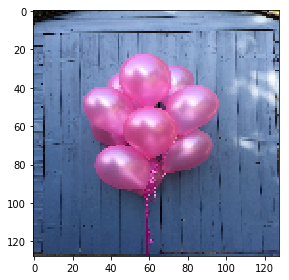

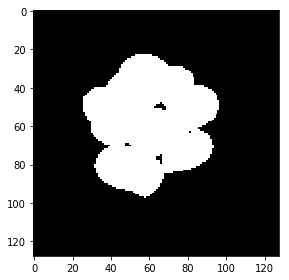

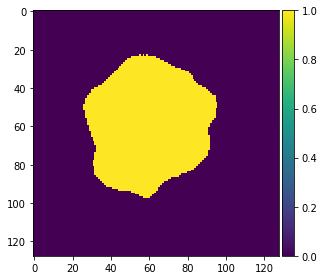

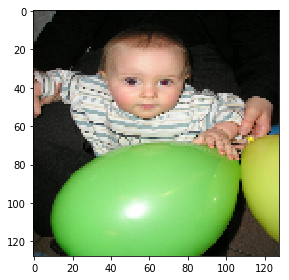

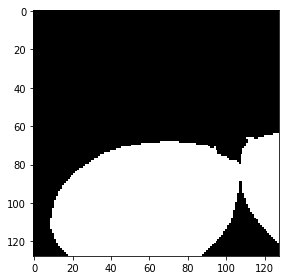

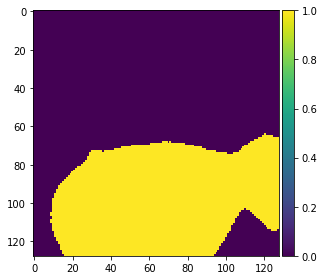

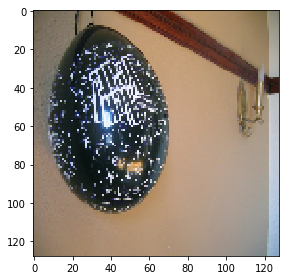

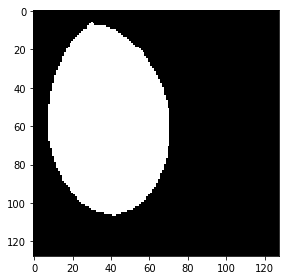

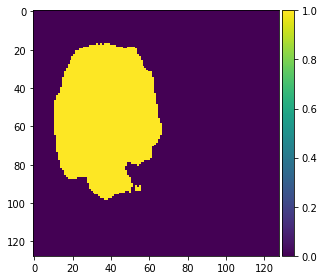

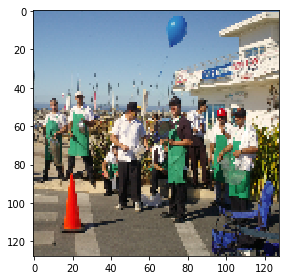

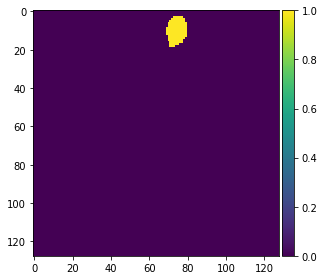

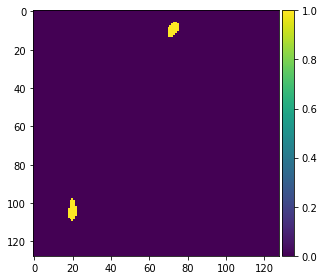

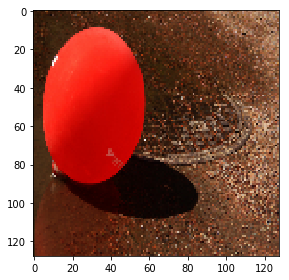

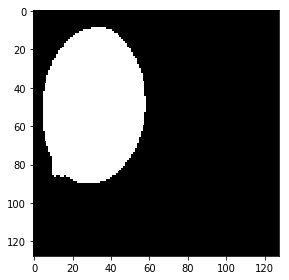

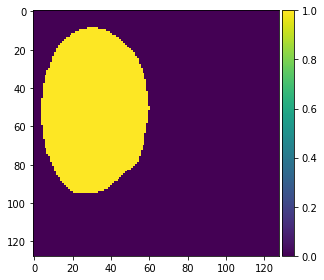

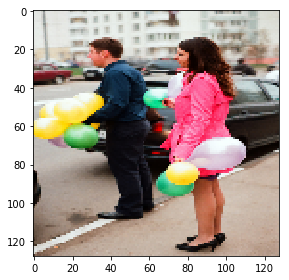

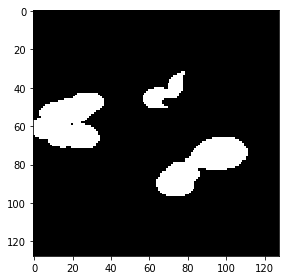

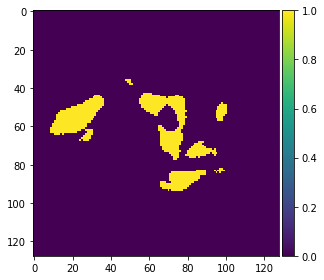

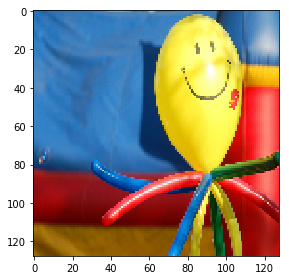

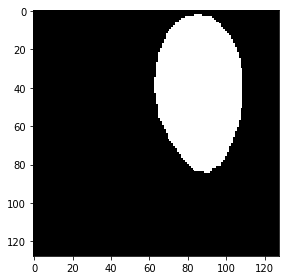

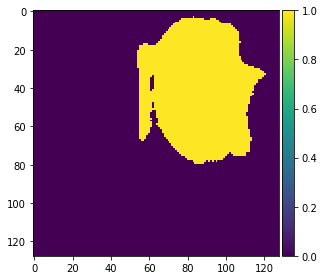

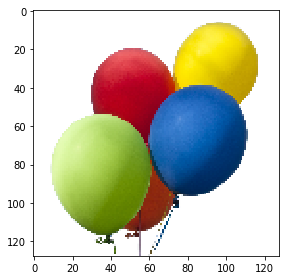

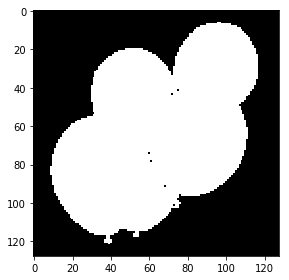

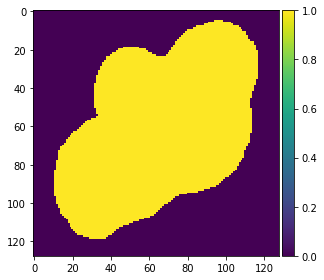

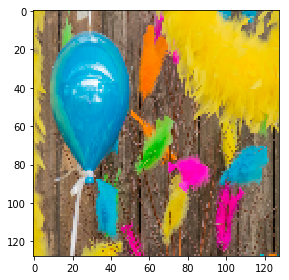

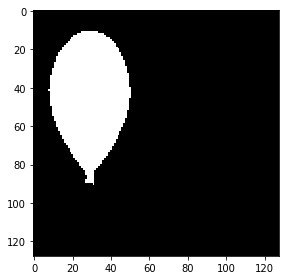

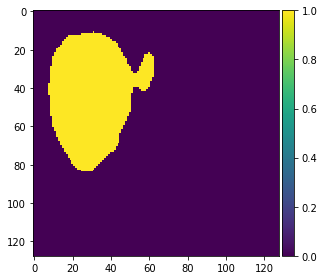

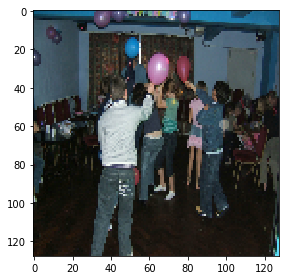

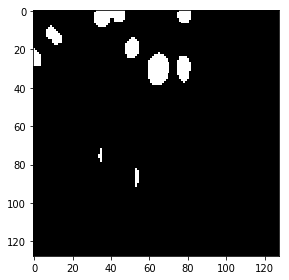

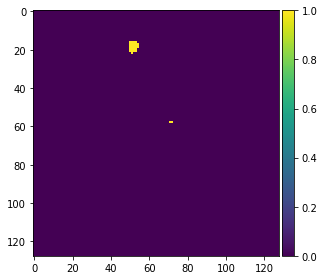

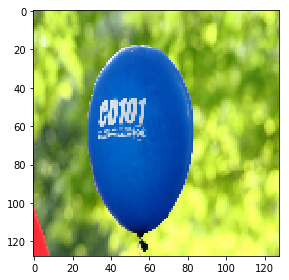

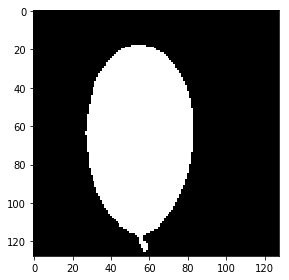

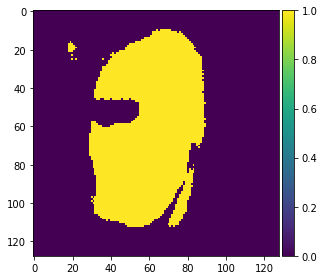

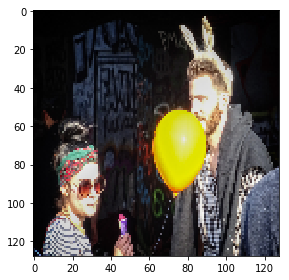

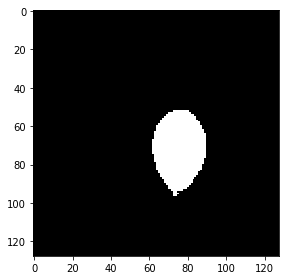

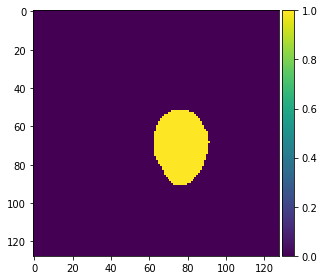

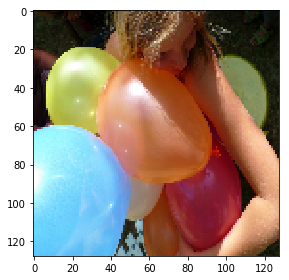

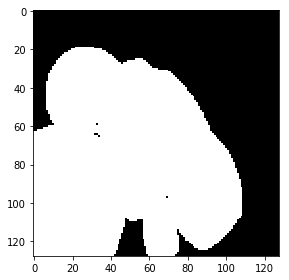

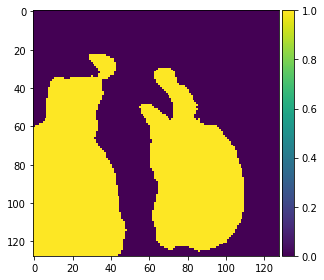

In [175]:
for ix in range(len(preds_train_t)):
    imshow(X_train[ix])
    plt.show()
    imshow(np.squeeze(Y_train[ix]))
    plt.show()
    imshow(np.squeeze(preds_train_t[ix]))
    plt.show()

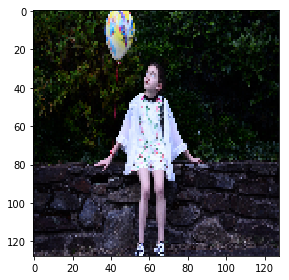

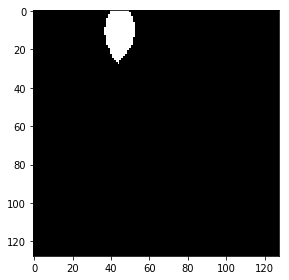

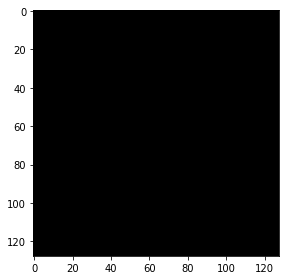

In [69]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

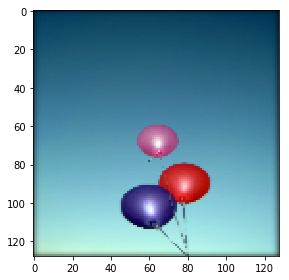

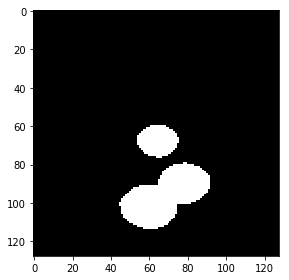

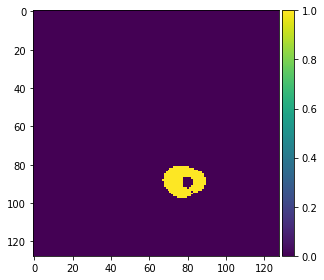

In [65]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

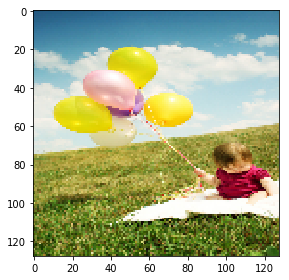

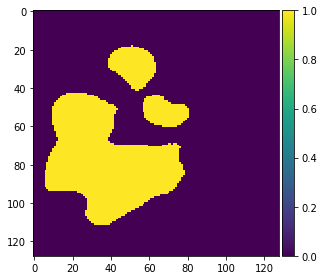

In [205]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()

## 画图函数
来自mask-RCNN
https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/visualize.py

In [324]:
import colorsys
import os
import sys
import logging
import random
import itertools
import colorsys

import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import IPython.display

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    掩膜 + 原图 
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def extract_bboxes(mask):
    """Compute bounding boxes from masks.
    mask: [height, width, num_instances]. Mask pixels are either 1 or 0.
    Returns: bbox array [num_instances, (y1, x1, y2, x2)].
    
    能力:给入(1429, 2048, 5),可以输出5个box,mask可能的取值内容为：
    array([[[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
    """
    boxes = np.zeros([mask.shape[-1], 4], dtype=np.int32)
    for i in range(mask.shape[-1]):
        m = mask[:, :, i]
        # Bounding box.
        horizontal_indicies = np.where(np.any(m, axis=0))[0]
        vertical_indicies = np.where(np.any(m, axis=1))[0]
        if horizontal_indicies.shape[0]:
            x1, x2 = horizontal_indicies[[0, -1]]
            y1, y2 = vertical_indicies[[0, -1]]
            # x2 and y2 should not be part of the box. Increment by 1.
            x2 += 1
            y2 += 1
        else:
            # No mask for this instance. Might happen due to
            # resizing or cropping. Set bbox to zeros
            x1, x2, y1, y2 = 0, 0, 0, 0
        boxes[i] = np.array([y1, x1, y2, x2])
    return boxes.astype(np.int32)

def display_instances(image, boxes, masks, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
#    else:
#        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

         # Label
        if not captions:
            score = scores[i] if scores is not None else None
            label = class_names
            x = random.randint(x1, (x1 + x2) // 2)
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()
    return masked_image.astype(np.uint8)


mask shape: (128, 128, 1)
image shape: (128, 128, 3)


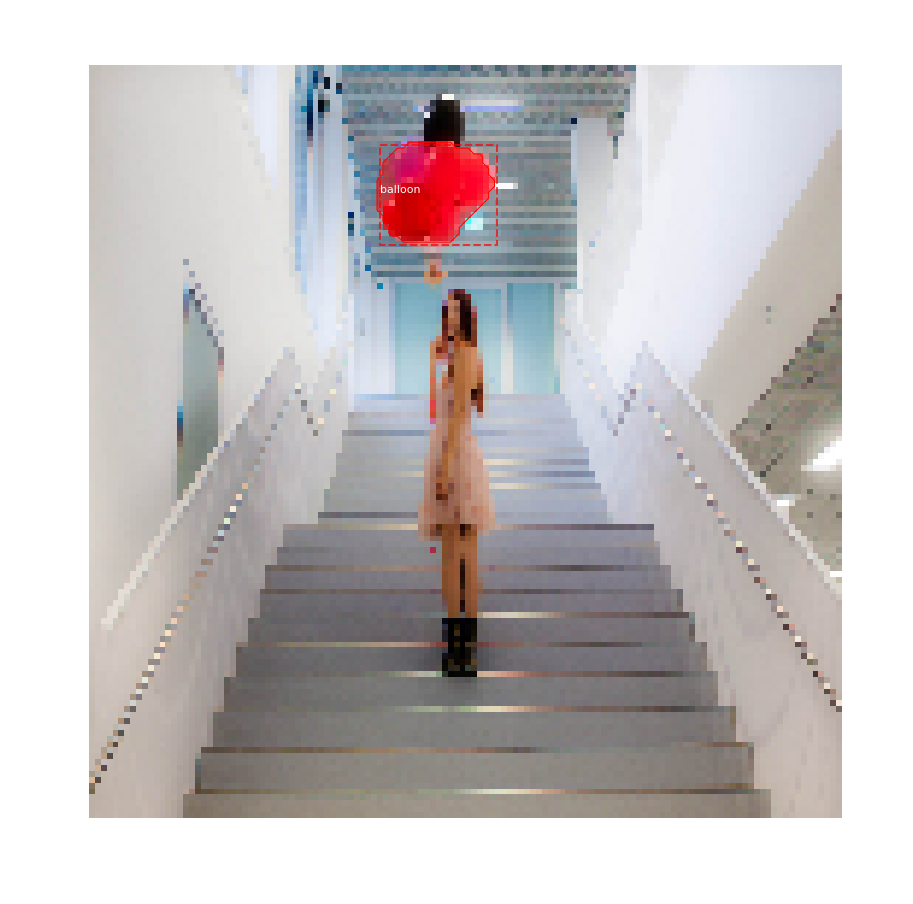

mask shape: (128, 128, 1)
image shape: (128, 128, 3)


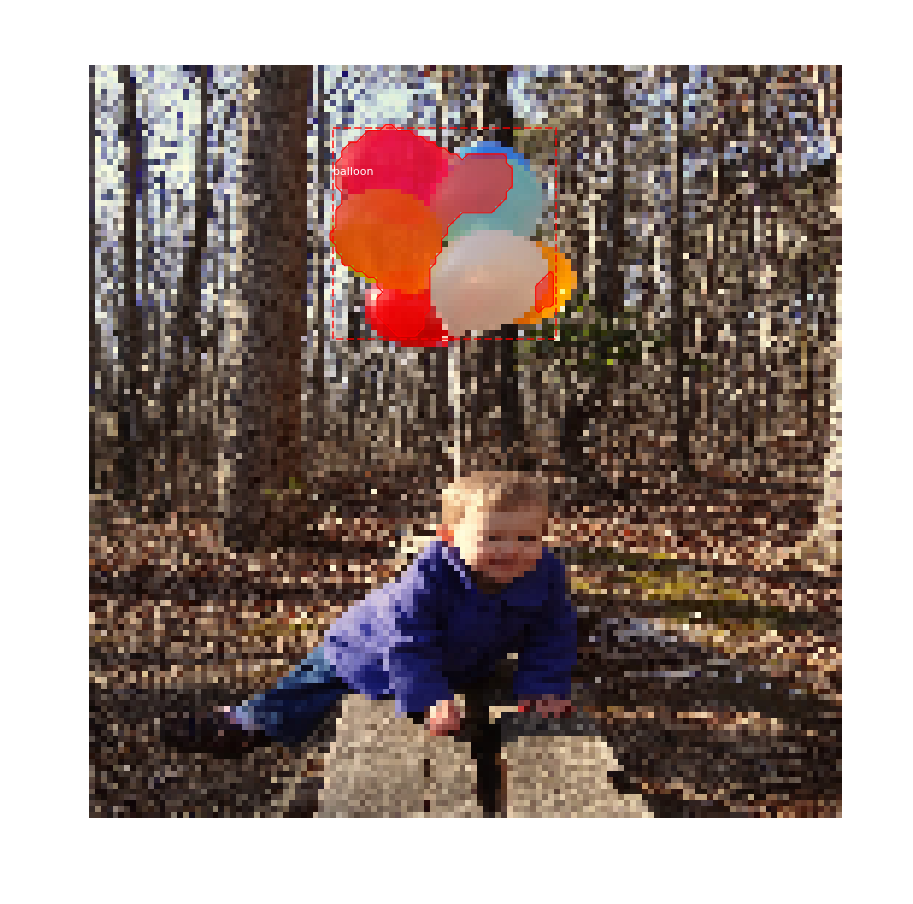

mask shape: (128, 128, 1)
image shape: (128, 128, 3)


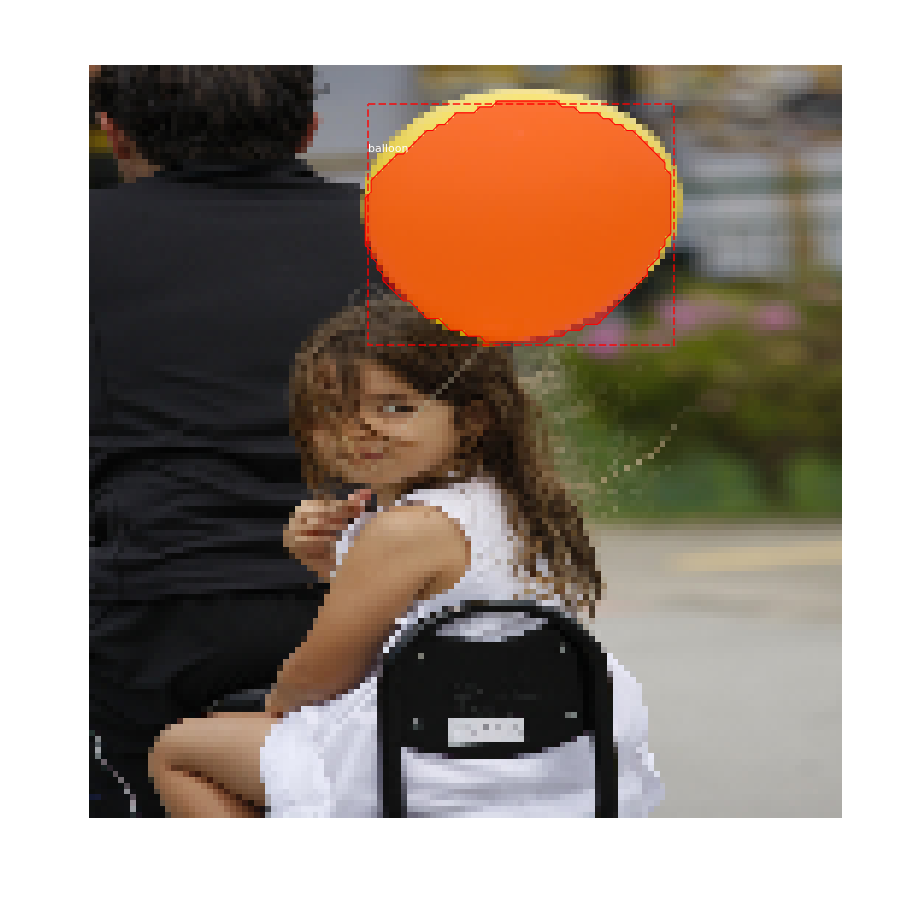

mask shape: (128, 128, 1)
image shape: (128, 128, 3)


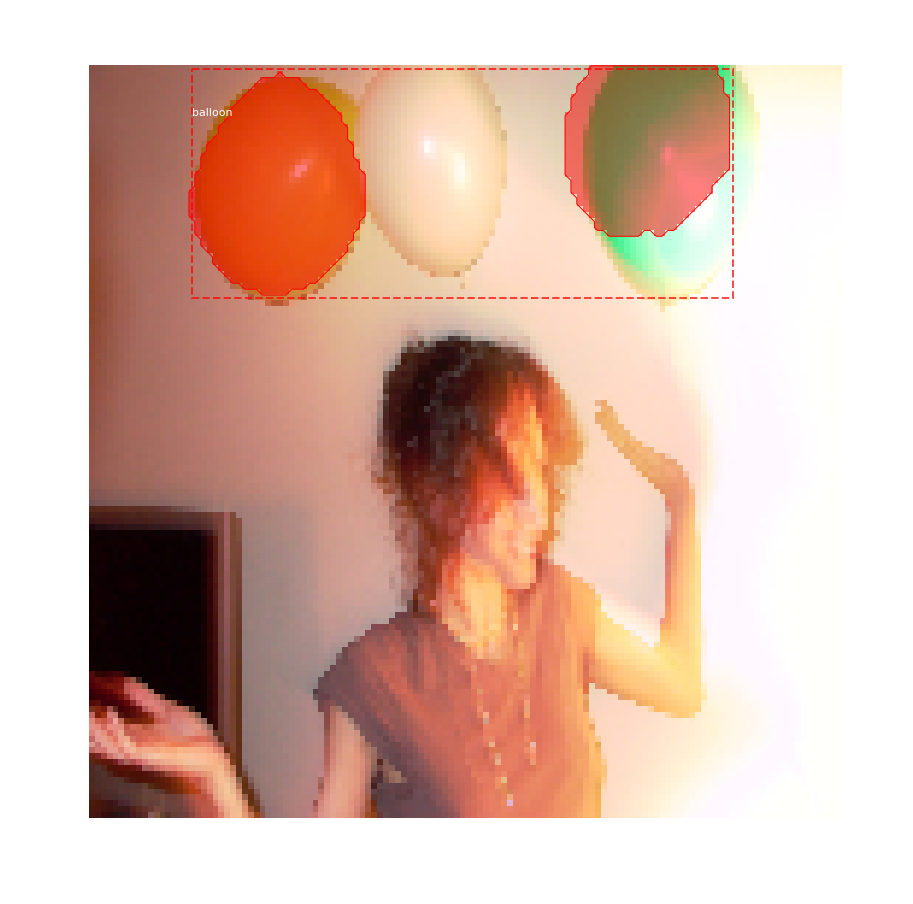

mask shape: (128, 128, 1)
image shape: (128, 128, 3)


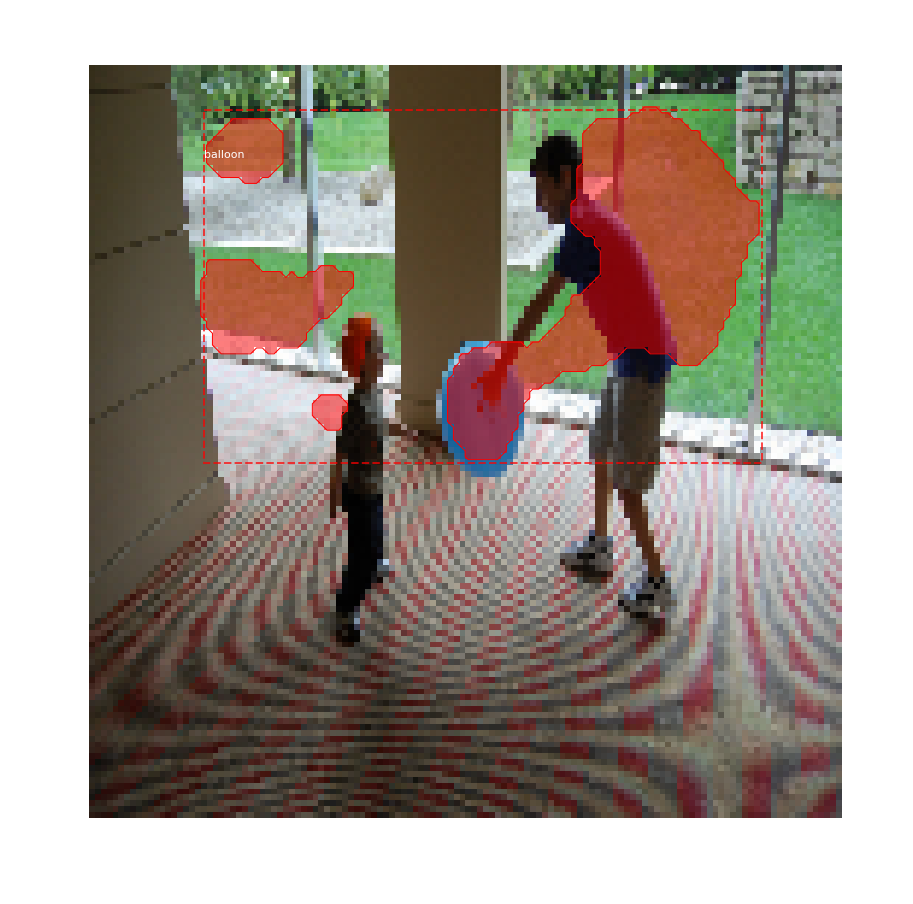

mask shape: (128, 128, 1)
image shape: (128, 128, 3)


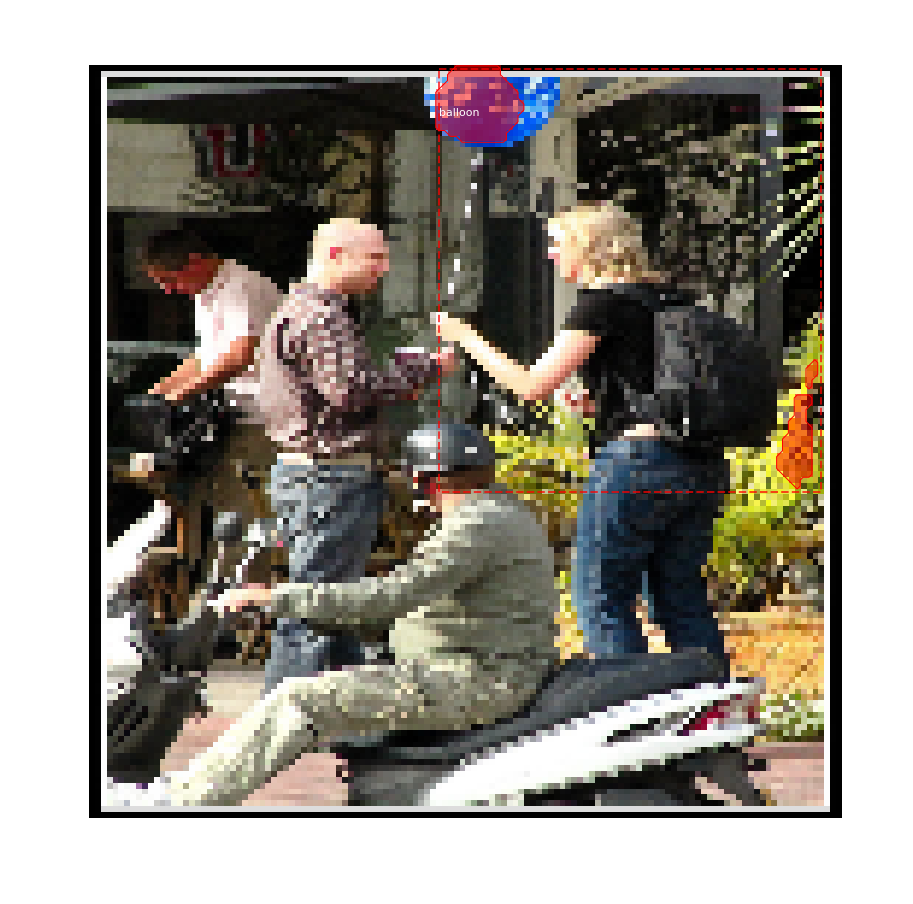

mask shape: (128, 128, 1)
image shape: (128, 128, 3)


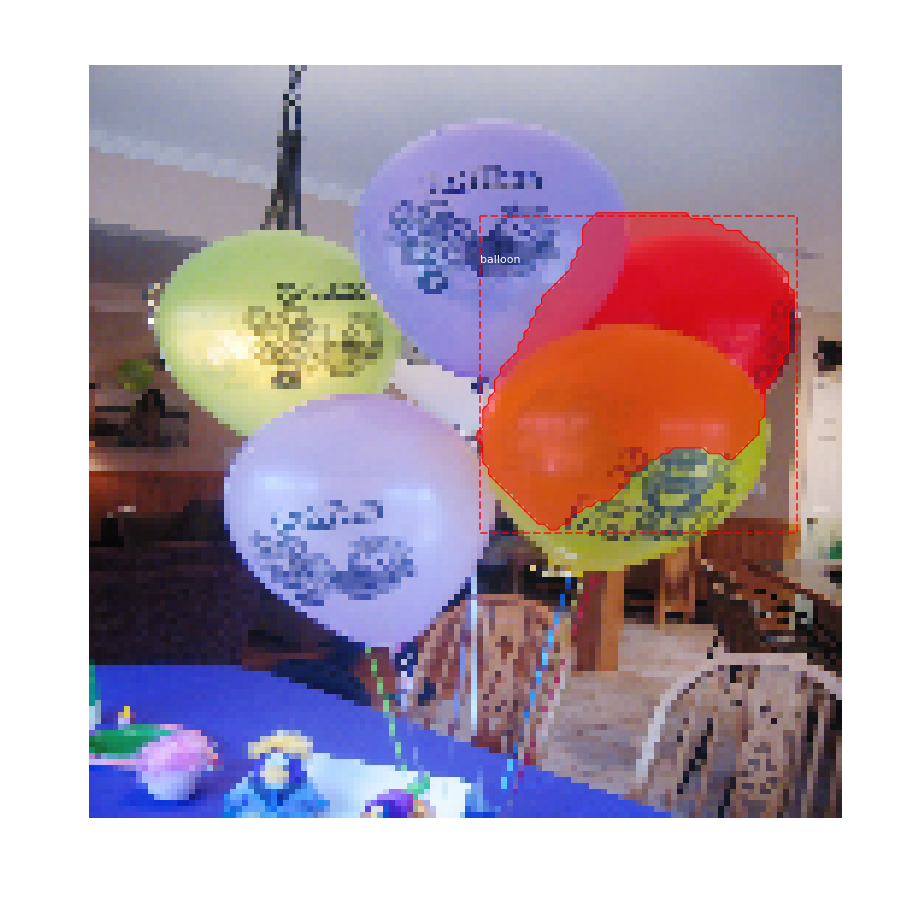

mask shape: (128, 128, 1)
image shape: (128, 128, 3)


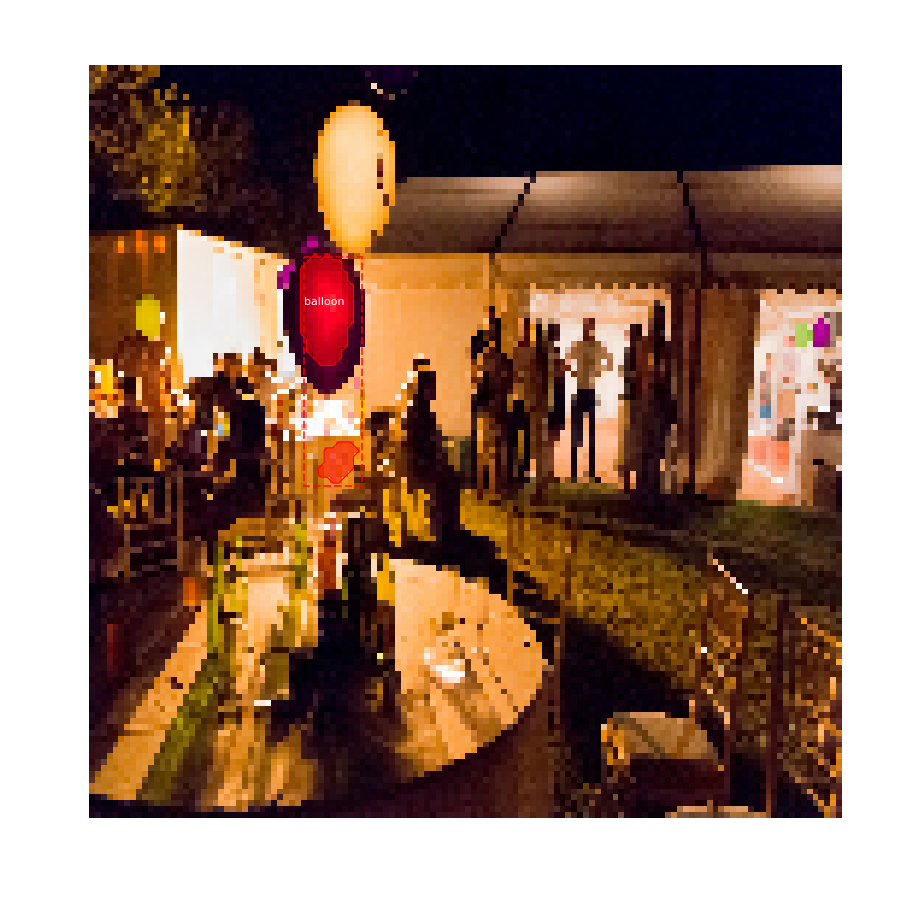

mask shape: (128, 128, 1)
image shape: (128, 128, 3)


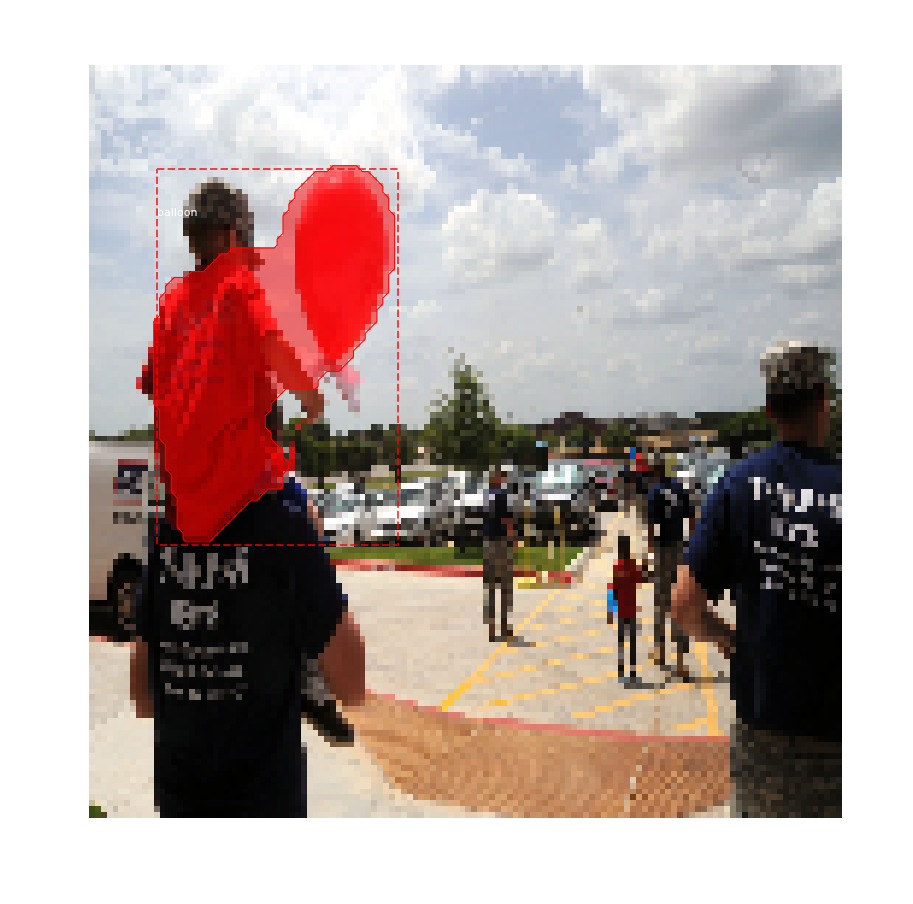

mask shape: (128, 128, 1)
image shape: (128, 128, 3)


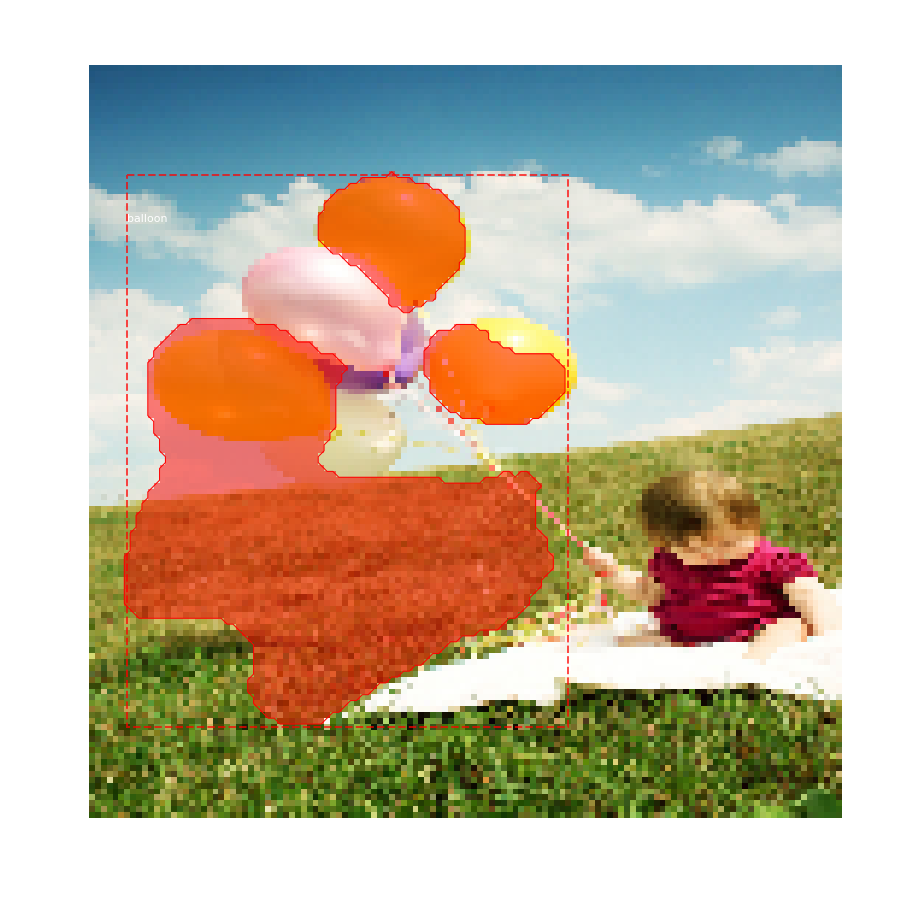

mask shape: (128, 128, 1)
image shape: (128, 128, 3)


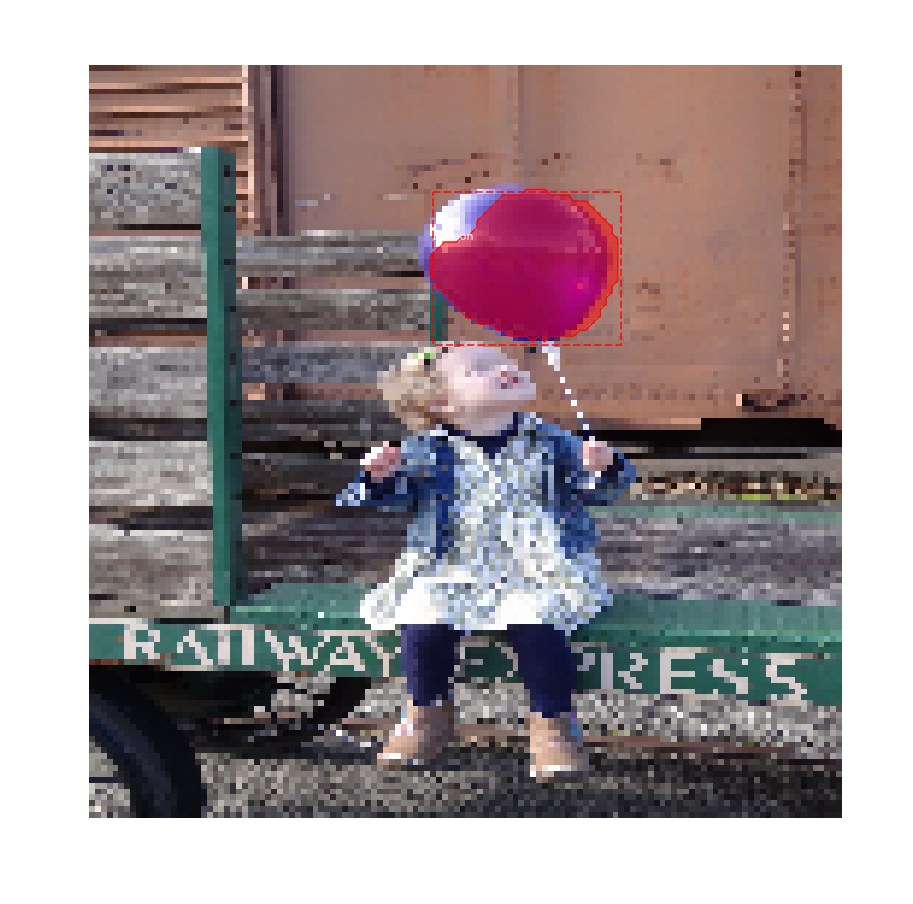

mask shape: (128, 128, 1)
image shape: (128, 128, 3)


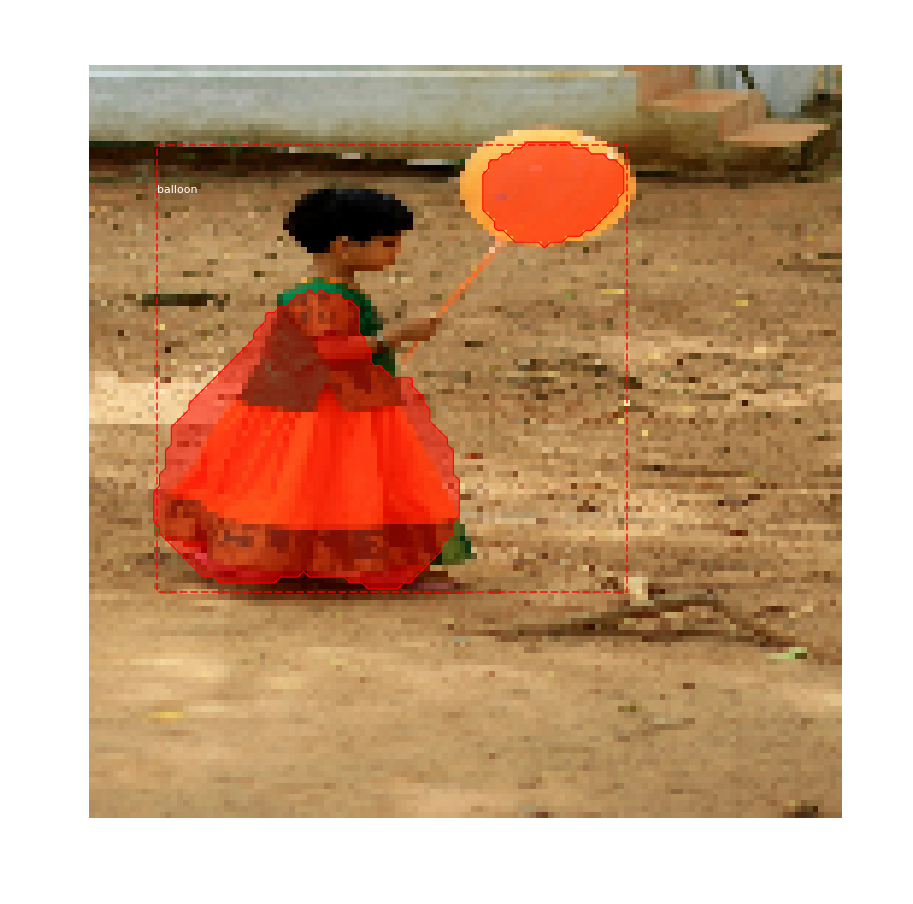

mask shape: (128, 128, 1)
image shape: (128, 128, 3)


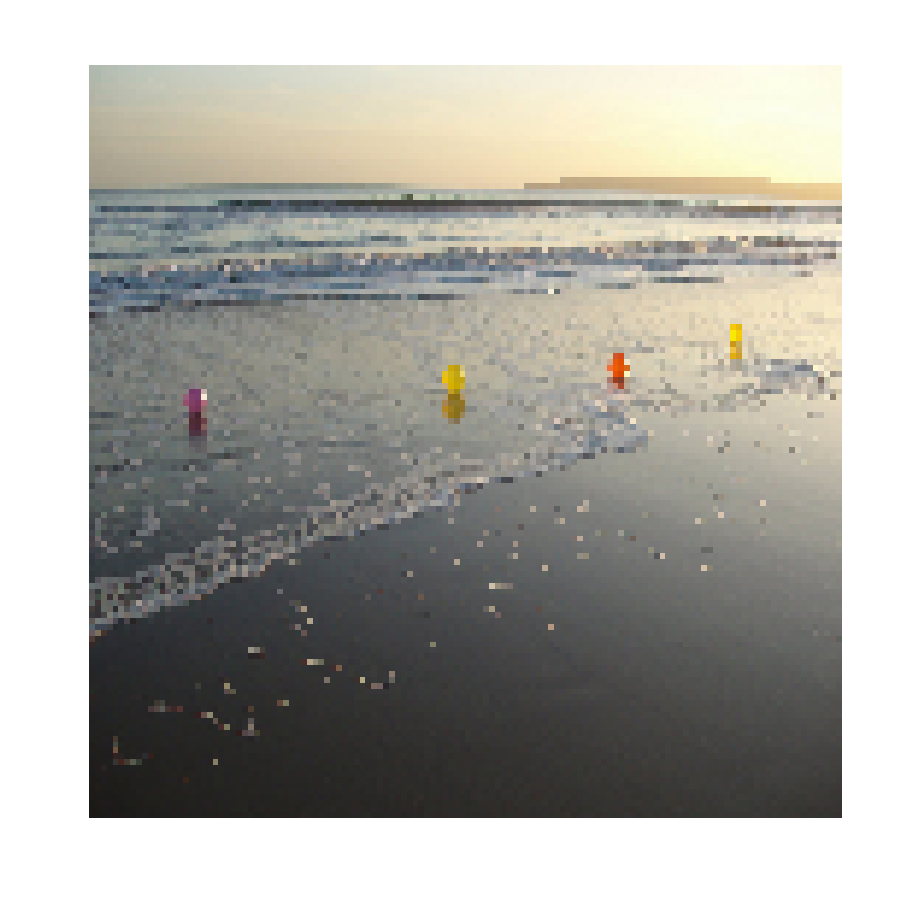

In [326]:
# Display image and instances
# 此时展示的是：128*128的图样

for i in range(len(preds_test_t)):
    image = X_test[i]
    bbox = extract_bboxes(preds_test_t[i])  # extract_bboxes(Y_train[i])    train_boxes[i]
    #mask = Y_test[i]
    mask = preds_test_t[i]
    class_names = 'balloon'
    print('mask shape:',mask.shape)
    print('image shape:',image.shape)

    mask_image = display_instances(image, bbox, mask, class_names)

    io.imsave('/mnt/unet/ball%s.jpg'%i, mask_image)

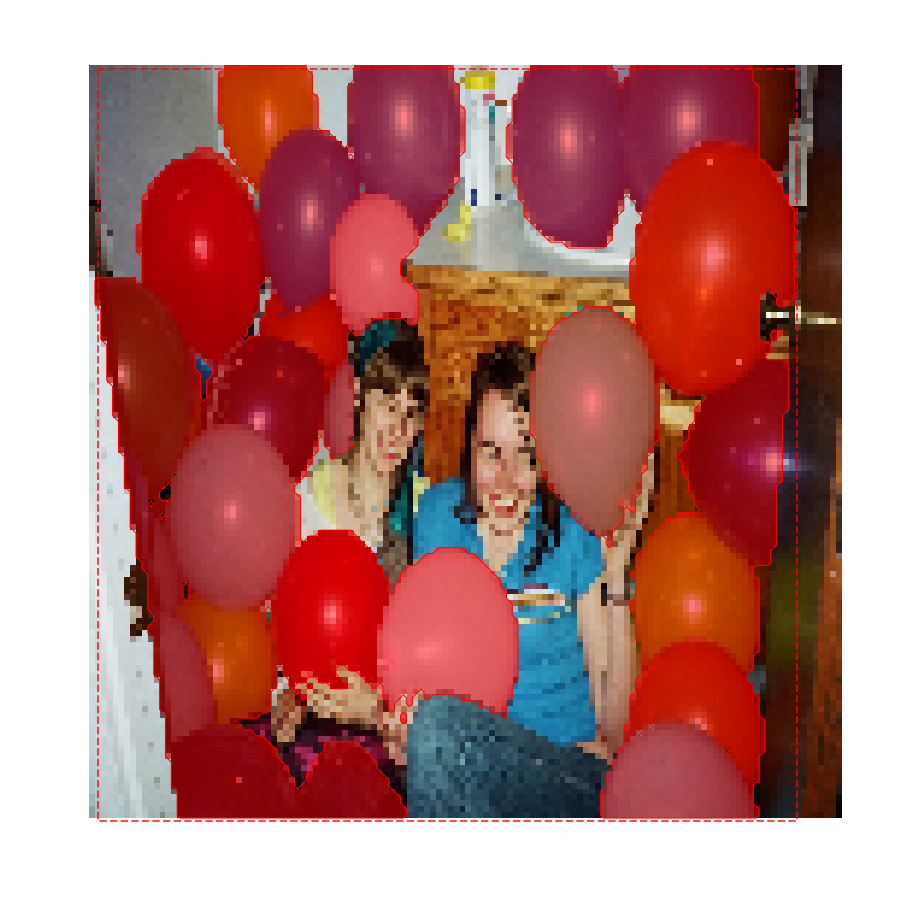

In [267]:
# Display image and instances
i = 0
image = X_train[i]
bbox = extract_bboxes(Y_train[i])  # extract_bboxes(Y_train[i])    train_boxes[i]
mask = Y_train[i]
class_names = 'name'

display_instances(image, bbox, mask, class_names)